In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score)  # Import function to calculate various metric
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
import sys
#from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', '..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [4]:
###-----------------
### Hyper Parameters
###-----------------
RANDOM_STATE=24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)
EPOCHS = 100 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 64 # mini batch size (number of rows)
PATIENCE=20 # for Early Stopping
LR_FACTOR =0.1#Reduction on LR Factor
LR_PATIENCE=5 # how long should i wait

In [5]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [6]:
train_filename = os.path.join('fashion-mnist_train.csv')
test_filename = os.path.join('fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [7]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [8]:
def fn_plot_label(tr_df,ts_df):
    plt.figure()
    plt.subplot(1,2,1)
    ax=tr_df['label'].value_counts().plot(kind='bar',title='Train',color='Purple',alpha=0.7)
    plt.subplot(1,2,2)
    ax=tr_df['label'].value_counts().plot(kind='bar',title='Test',color='Red',alpha=0.7)

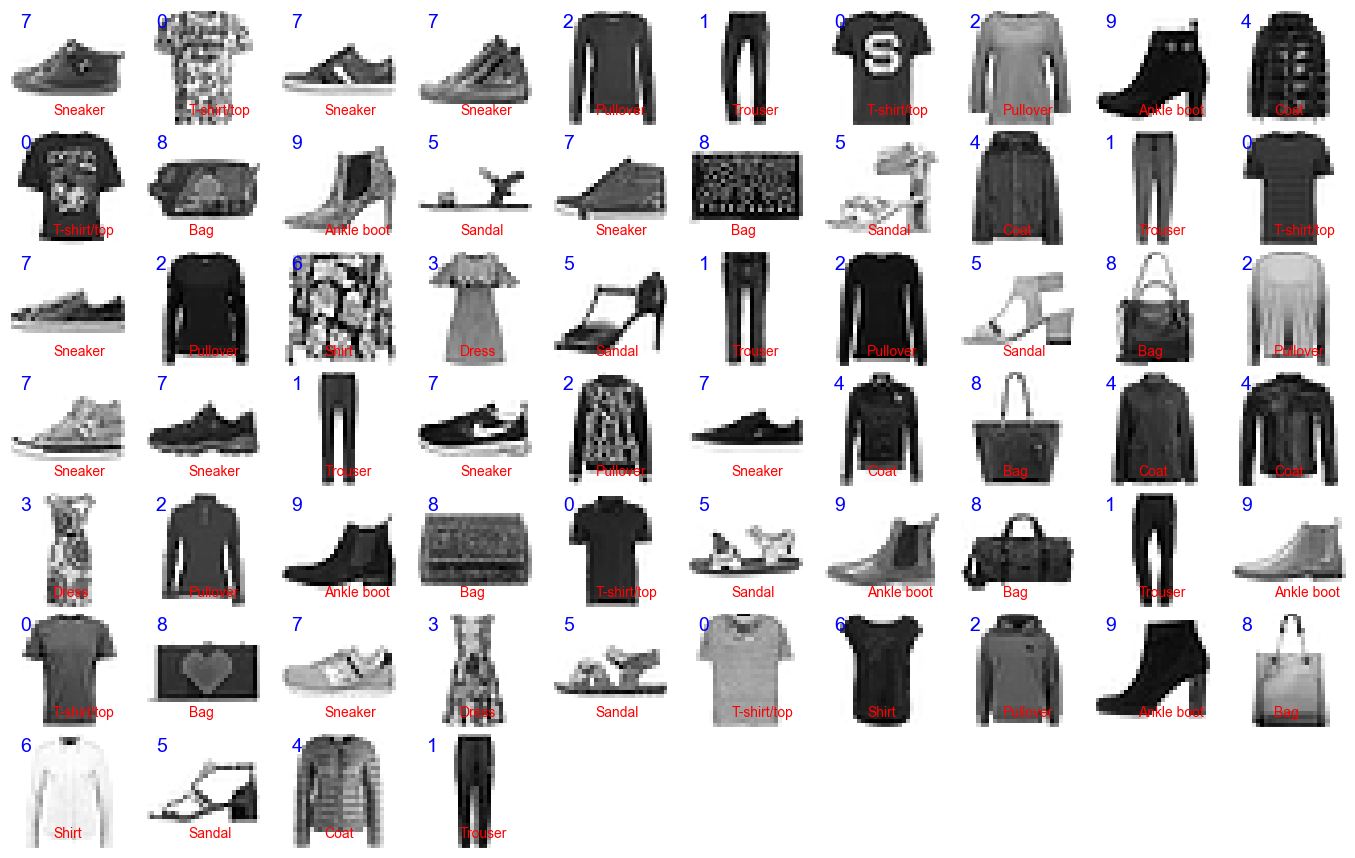

In [9]:
 #Sample data plot
plot_df=train_df.sample(n=BATCH_SIZE)
fig=plt.figure(figsize = (15,12))
fig.subplots_adjust(left=0,bottom=0,top=1,hspace=0.05,wspace=0.05)
i=0
for _,row in plot_df.iterrows():
    i=i+1
    image=row.values[1:].reshape(28,28)
    ax=fig.add_subplot(10,10,(i),xticks=[],yticks=[])
    ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest')
    ax.text(2,4,str(row.iloc[0]),color='b',fontsize=14)
    ax.text(10,25,class_names[row.iloc[0]],color='r',fontsize=10)
plt.show()

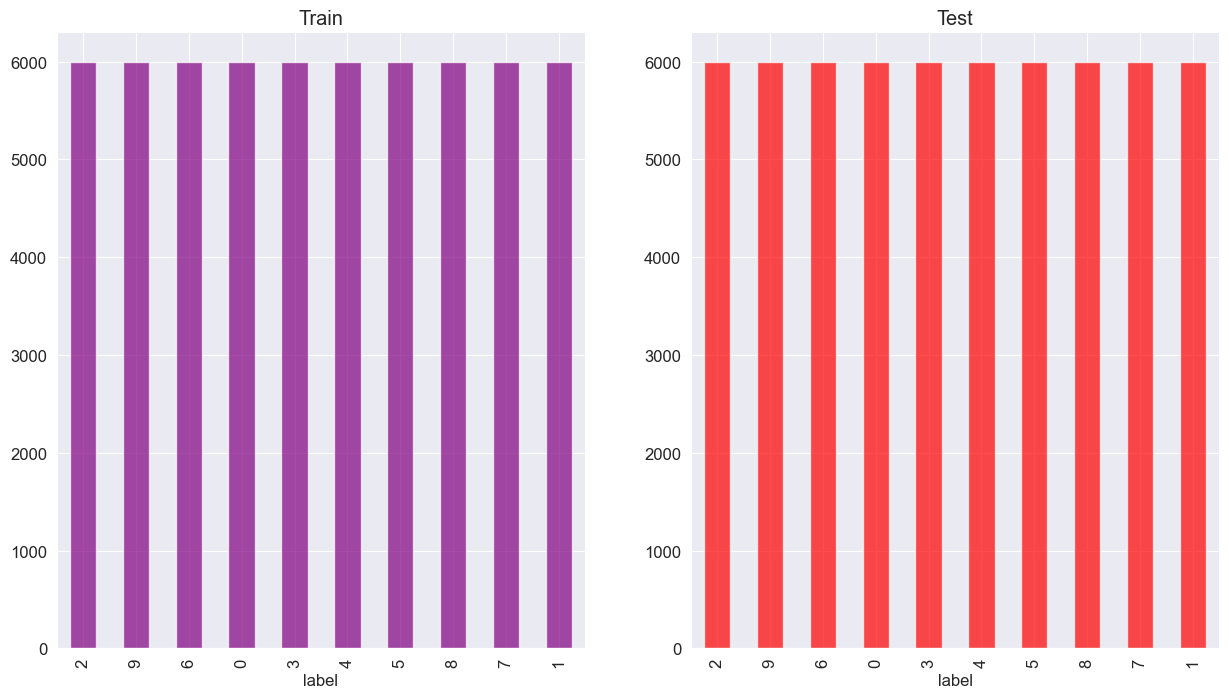

In [10]:
fn_plot_label(train_df,test_df)

In [11]:
def split_feature_label(row):
    print(row[:1])
    feature=tf.reshape(row[1:],[28,28,1])
    label=row[0]
    return feature,label

In [12]:
tmp_ds=tf.data.Dataset.from_tensor_slices(train_df)
train_ds=tmp_ds.map(split_feature_label)
train_ds=train_ds.batch(batch_size=BATCH_SIZE)
tmp_ds=tf.data.Dataset.from_tensor_slices(test_df)
test_ds=tmp_ds.map(split_feature_label)
test_ds=test_ds.batch(batch_size=BATCH_SIZE)

Tensor("strided_slice:0", shape=(1,), dtype=int64)
Tensor("strided_slice:0", shape=(1,), dtype=int64)


In [13]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

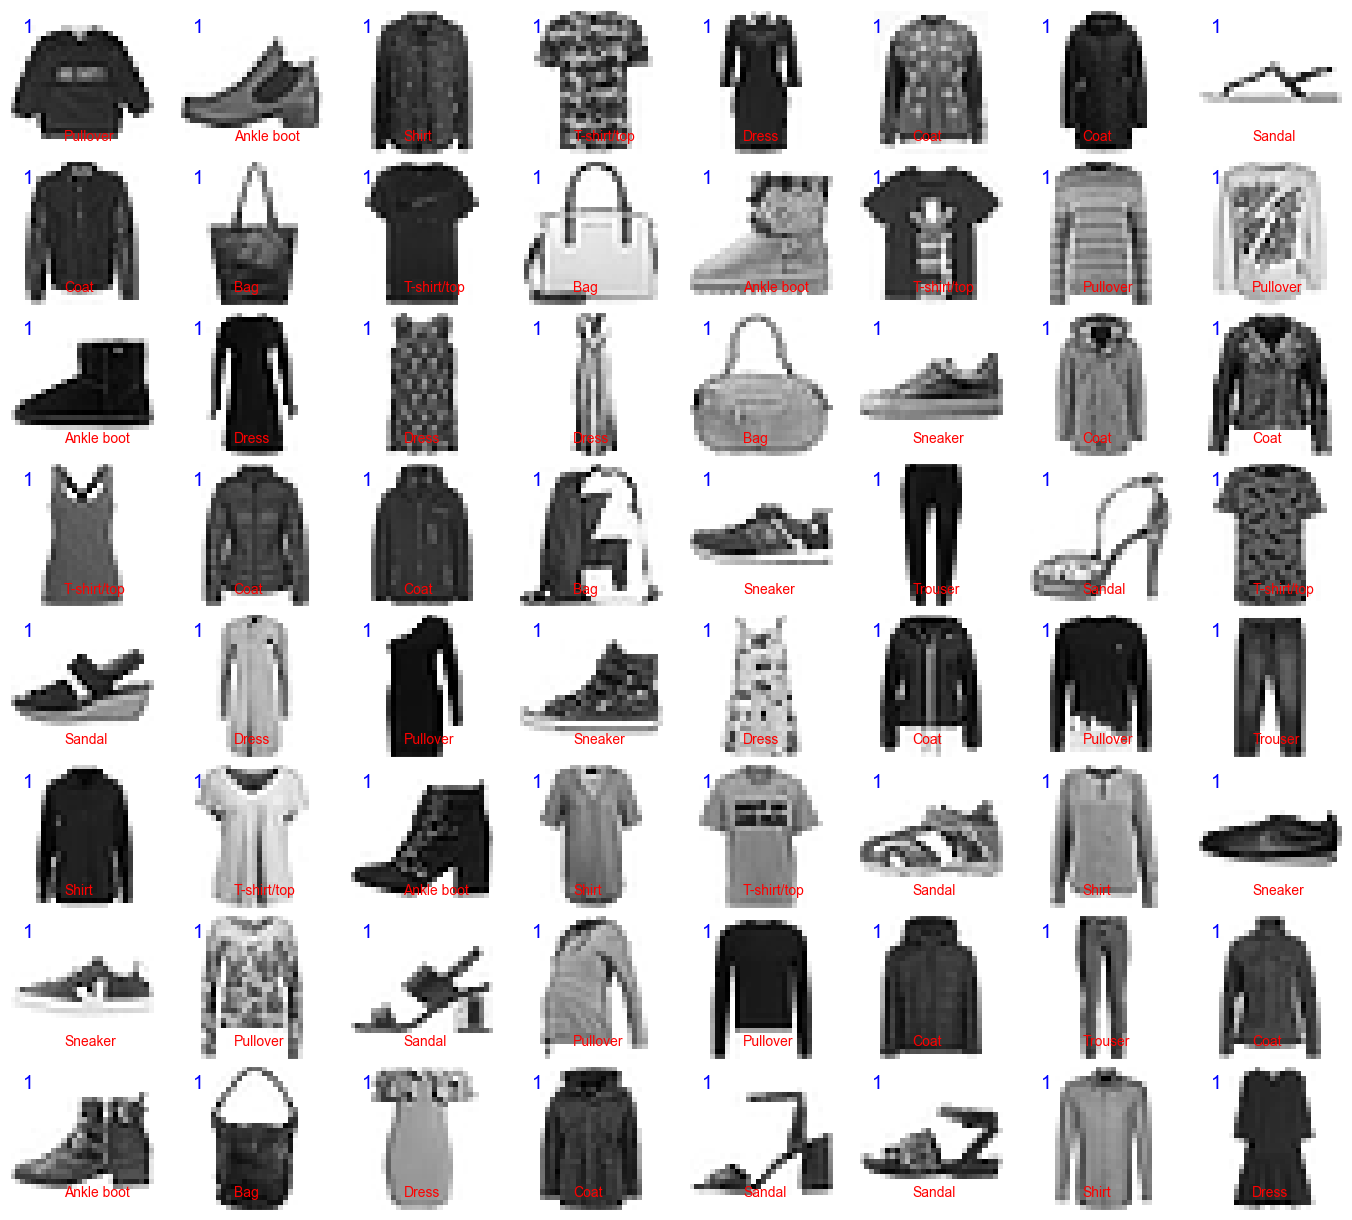

In [14]:

fig=plt.figure(figsize = (15,12))
fig.subplots_adjust(left=0,bottom=0,top=1,hspace=0.05,wspace=0.05)
i=0
for images,labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax=fig.add_subplot(BATCH_SIZE//8,8,(i+1),xticks=[],yticks=[])
        ax.imshow(images[i].numpy().astype('uint8'),cmap=plt.cm.binary)
        ax.text(2,4,str(row.iloc[0]),color='b',fontsize=14)
        ax.text(10,25,class_names[labels[i].numpy()],color='r',fontsize=10)
plt.show()

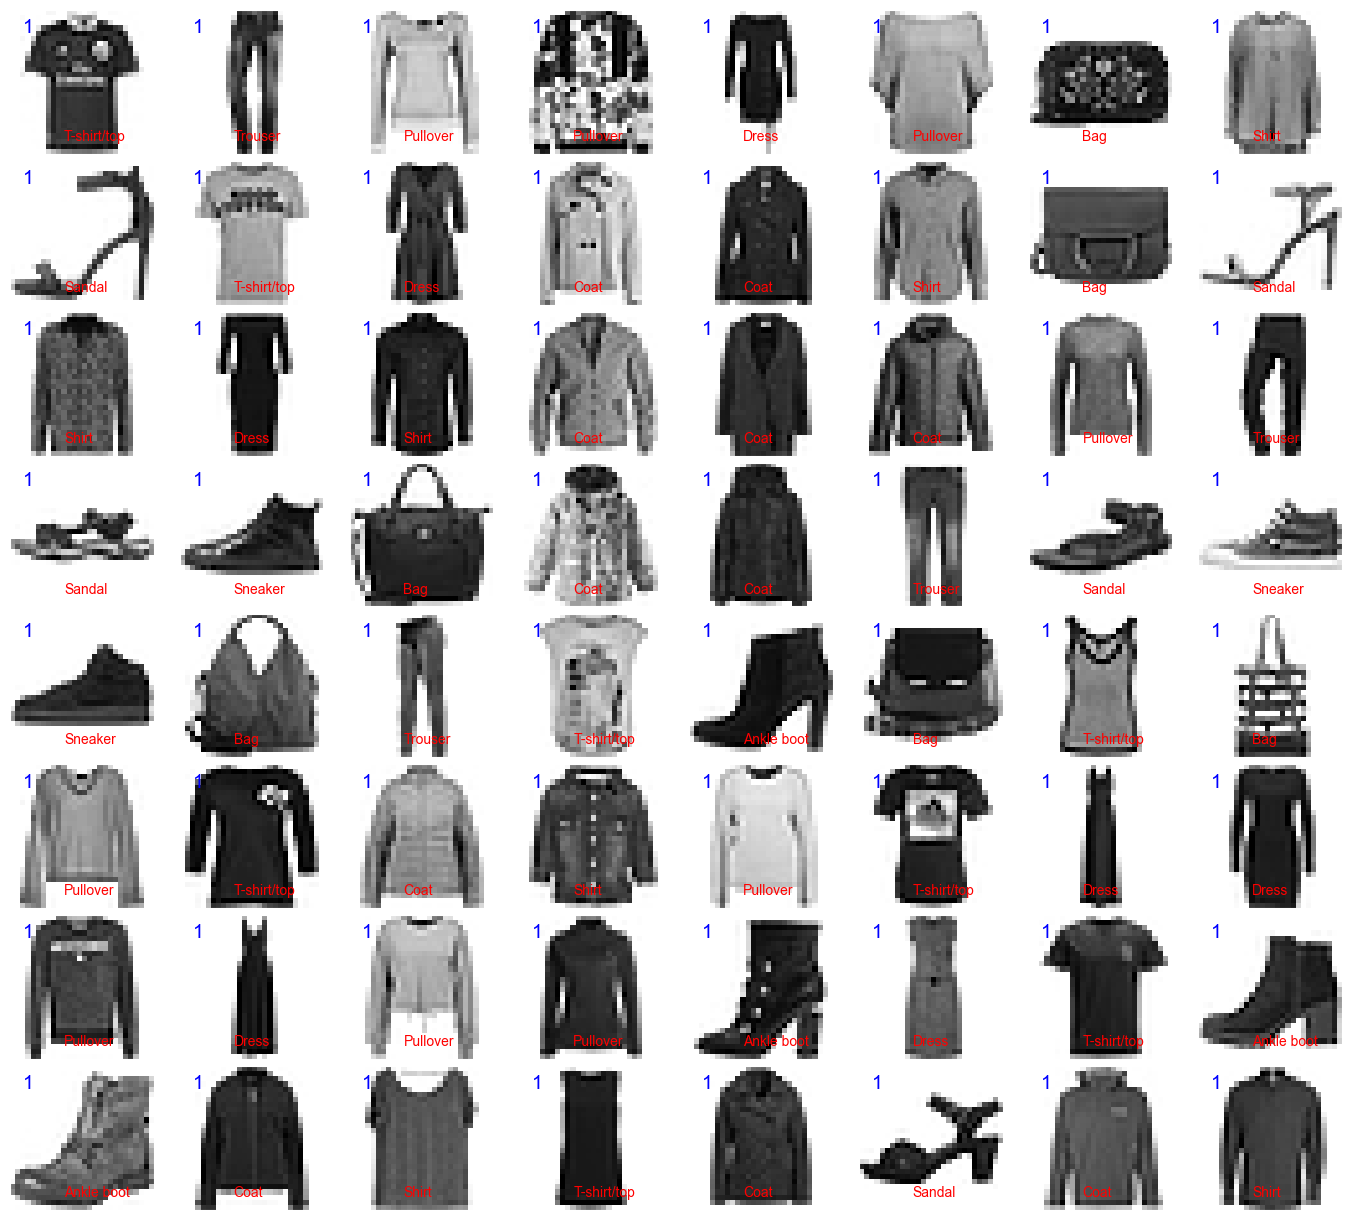

In [15]:
fig=plt.figure(figsize = (15,12))
fig.subplots_adjust(left=0,bottom=0,top=1,hspace=0.05,wspace=0.05)
i=0
for images,labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax=fig.add_subplot(BATCH_SIZE//8,8,(i+1),xticks=[],yticks=[])
        ax.imshow(images[i].numpy().astype('uint8'),cmap=plt.cm.binary)
        ax.text(2,4,str(row.iloc[0]),color='b',fontsize=14)
        ax.text(10,25,class_names[labels[i].numpy()],color='r',fontsize=10)
plt.show()

Build the Model

In [16]:
images[0].shape

TensorShape([28, 28, 1])

In [17]:
input_shape=(28,28,1)
dor1=0.3
dor2=0.3
dor3=0.3
dor4=0.3
regularizer=tf.keras.regularizers.L2(0.001)

model=tf.keras.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(tf.keras.layers.Rescaling(1.0/255))

#   Set 1
model.add(tf.keras.layers.Conv2D(32,(3,3),padding='same'))    #(28x28x32)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D() )#(14x14x32)
model.add(tf.keras.layers.Dropout(dor1))
#   Set 2
model.add(tf.keras.layers.Conv2D(64,(3,3)))  #(12x12x64)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.MaxPool2D()) #(6x6x64)
model.add(tf.keras.layers.Dropout(dor2))
#   Set 3
model.add(tf.keras.layers.Conv2D(128,(3,3)))    #(4x4x128)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(dor3))
model.add(tf.keras.layers.Flatten()) #(14x14x32)

#Head

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(dor4))
model.add(tf.keras.layers.Dense(10))

optimizer = tf.keras.optimizers.AdamW(learning_rate=ALPHA)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy, metrics=['accuracy'])

Callbacks

In [18]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = PATIENCE,
    verbose = 1,
    restore_best_weights = True,
    min_delta = 0
)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose = 1,
    min_lr = 1e-6,
)


In [19]:
hist=model.fit(train_ds,validation_data=test_ds,epochs=EPOCHS,callbacks=[es_callback,lr_callback])

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.5833 - loss: 2.1144 - val_accuracy: 0.5509 - val_loss: 2.4006 - learning_rate: 0.0010
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.5173 - loss: 1.8330 - val_accuracy: 0.6207 - val_loss: 1.7513 - learning_rate: 0.0010
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.2432 - loss: 2.3435 - val_accuracy: 0.3082 - val_loss: 2.3021 - learning_rate: 0.0010
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.2152 - loss: 2.3051 - val_accuracy: 0.3479 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.2291 - loss: 2.3010 - val_accuracy: 0.3810 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.2339 - loss: 2.3032 - val_accuracy: 0.3917 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 7/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.24

In [20]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy()[0], color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

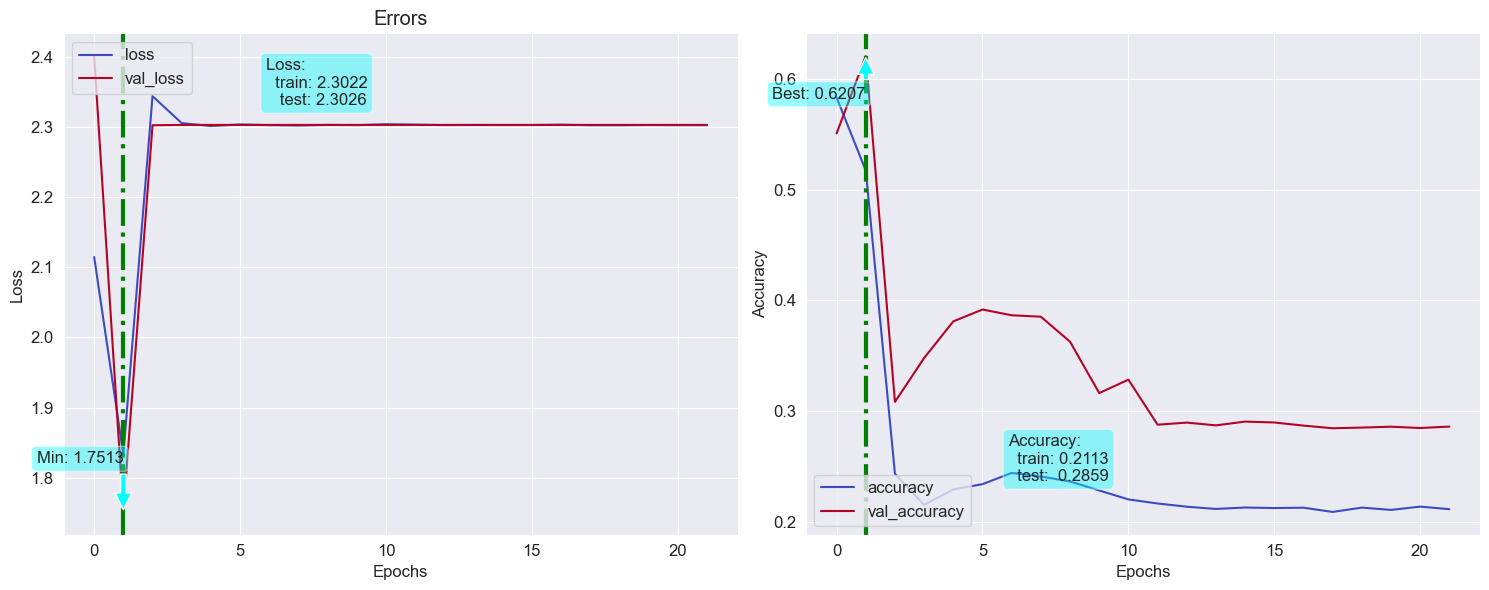

In [21]:
loss_df = pd.DataFrame(hist.history)
fn_plot_tf_hist(loss_df)
plt.show()

Evaluate Accuracy

In [22]:
y_train=tf.concat([y for x,y in train_ds],axis=0).numpy()
print('\nTrain Shape:',y_train.shape)


Train Shape: (60000,)


Make Prdedictions

In [23]:
yhat=model.predict(train_ds)
y_pred=yhat.argmax(axis=1)
print(f'Accuracy:{accuracy_score(y_train,y_pred):.5f}')
print(classification_report)

938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
Accuracy:0.62125
<function classification_report at 0x000001BB4F2D6660>


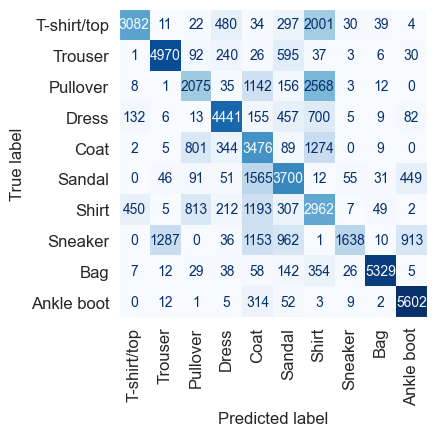

In [24]:
fn_plot_confusion_matrix(y_train,y_pred,class_names)

For testing data

In [25]:
y_test=tf.concat([y for x,y in test_ds],axis=0).numpy()
print('\nTest Shape:',y_test.shape)


Test Shape: (10000,)


In [26]:
yhat=model.predict(test_ds)
y_pred=yhat.argmax(axis=1)
print(f'Accuracy:{accuracy_score(y_test,y_pred):.5f}')
print(classification_report)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy:0.62070
<function classification_report at 0x000001BB4F2D6660>


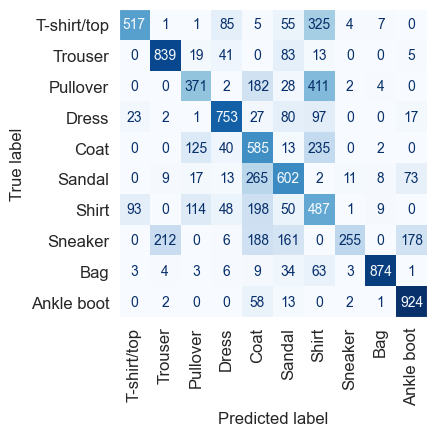

In [27]:
fn_plot_confusion_matrix(y_test,y_pred,class_names)

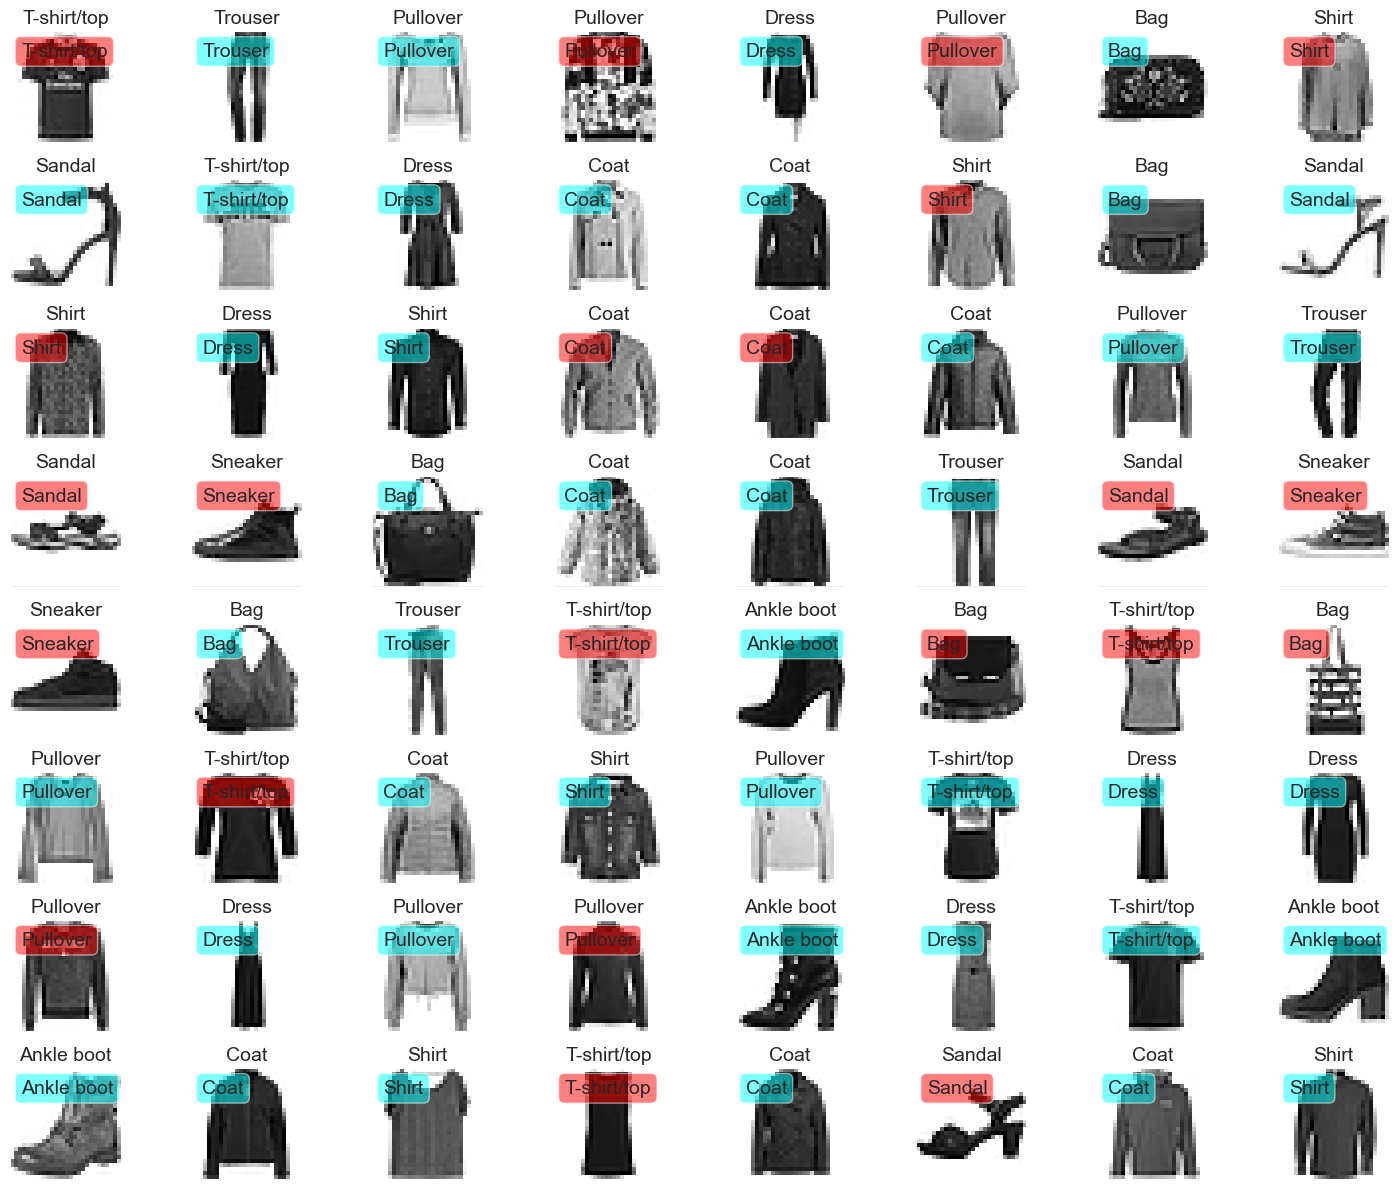

In [28]:
fig=plt.figure(figsize = (15,12))
fig.subplots_adjust(left=0, right=1, bottom=0,top=1,hspace=0.05,wspace=0.05)

for images,labels in test_ds.take(1):
    yhat=model(images).numpy()
    y_pred=yhat.argmax(axis=1)
    for i in range(BATCH_SIZE):
        ax=fig.add_subplot(BATCH_SIZE//8,8,(i+1),xticks=[],yticks=[])
        ax.grid(False)
        color='cyan'
        if y_pred[i]!=labels[i]:
            color='red'
        props=dict(boxstyle='round', facecolor=color, alpha=0.5)
        ax.imshow(images[i].numpy().astype('uint8'),cmap=plt.cm.binary)
        ax.text(0.1,0.9,class_names[labels[i].numpy()],bbox=props,verticalalignment='top',transform=ax.transAxes,fontsize=14)   #add number class of the image
        ax.set_title(class_names[labels[i].numpy()],fontsize=14)
plt.tight_layout()
plt.show()